In [1]:
import sys, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  # or accuracy_score, etc.
import pandas as pd
import lightgbm as lgb

from src.data import DataLoader
from src.evaluate import evaluate
from src.preprocessing import PreProcessClass


In [2]:
sys.path.append(str(Path("Alpiq ETHdatathon challenge 2025").resolve()))
from data import DataLoader, SimpleEncoding
input_path = "Alpiq ETHdatathon challenge 2025/datasets2025/"
loader = DataLoader(input_path)

In [ ]:
def evaluate(
    pred_it: pd.DataFrame,
    pred_es: pd.DataFrame,
    true_it: pd.DataFrame,
    true_es: pd.DataFrame,
    top_k: int = 3,  # Show top-k worst consumers
) -> pd.DataFrame:
    """Evaluate forecast, print scores and show diagnostics."""

    absolute_error = {}
    portfolio_error = {}
    consumer_errors = {}  # For diagnostic plots and tables

    for country in ["ES", "IT"]:

        student_solution = pred_es if country == "ES" else pred_it
        testing_set = true_es if country == "ES" else true_it


        # Core errors
        abs_err = (student_solution - testing_set).abs().sum().sum()
        print((student_solution - testing_set).clip(0).abs().sum().sum())
        port_err = (student_solution - testing_set).sum(axis=1).abs().sum()

        absolute_error[country] = abs_err
        portfolio_error[country] = port_err

        # Store per-consumer error
        consumer_abs_error = (student_solution - testing_set).abs().sum()
        consumer_errors[country] = consumer_abs_error.sort_values(ascending=False)

    # === Official scoring table ===
    forecast_score = (
        1.0 * absolute_error["IT"]
        + 5.0 * absolute_error["ES"]
        + 10.0 * portfolio_error["IT"]
        + 50.0 * portfolio_error["ES"]
    )

    score_table = pd.DataFrame(
        {"Absolute Error": absolute_error, "Portfolio Error": portfolio_error}
    ).T

    score_table["Weight IT"] = [1.0, 10.0]  # IT weights
    score_table["Weighted IT"] = score_table["IT"] * score_table["Weight IT"]
    score_table["Weight ES"] = [5.0, 50.0]  # ES weights
    score_table["Weighted ES"] = score_table["ES"] * score_table["Weight ES"]
    score_table = score_table[
        ["IT", "Weight IT", "Weighted IT", "ES", "Weight ES", "Weighted ES"]
    ]
    score_table.columns.name = "Metric"

    score_it = score_table[["IT", "Weight IT", "Weighted IT"]]
    score_it = score_it.rename(
        columns={"IT": "Score", "Weight IT": "Weight", "Weighted IT": "Weighted Score"}
    )
    score_es = score_table[["ES", "Weight ES", "Weighted ES"]]
    score_es = score_es.rename(
        columns={"ES": "Score", "Weight ES": "Weight", "Weighted ES": "Weighted Score"}
    )

    print("\n" + "=" * 60)
    print("FORECAST EVALUATION REPORT".center(60))
    print("=" * 60 + "\n")
    print("IT PERFORMANCE")
    print("-" * 60 + "\n")
    print(score_it)
    print(f"\nTop {top_k} consumers with highest error in Italy:\n")
    print(consumer_errors["IT"].head(top_k).round(2).to_string())

    print("\nES PERFORMANCE")
    print("-" * 60 + "\n")
    print(score_es)
    print(f"\nTop {top_k} consumers with highest error in Spain:\n")
    print(consumer_errors["ES"].head(top_k).round(2).to_string())

    print("\n" + "-" * 60)
    print("TOTAL FORECAST SCORE".center(60))
    print(f"{int(round(forecast_score))}".center(60))
    print("-" * 60 + "\n")


**Italy preprocessing**

In [3]:
consumptions, features, example_solution = loader.load_data("IT")
preprocessor_it = PreProcessClass(consumptions, features)

col_customersIT = [id for id in consumptions.columns if id.startswith("VALUEMWHMETERINGDATA_customerIT")]
dataIT = preprocessor_it.preprocess_nonan(col_customersIT)

dataIT = dataIT.reset_index()
dataIT = dataIT.rename(columns={"index": "DateTime"})
dataIT.head()

,DateTime,VALUEMWHMETERINGDATA_customerIT_1,VALUEMWHMETERINGDATA_customerIT_2,VALUEMWHMETERINGDATA_customerIT_3,VALUEMWHMETERINGDATA_customerIT_4,VALUEMWHMETERINGDATA_customerIT_5,VALUEMWHMETERINGDATA_customerIT_6,VALUEMWHMETERINGDATA_customerIT_7,VALUEMWHMETERINGDATA_customerIT_8,VALUEMWHMETERINGDATA_customerIT_13,...,Day,Month,Year,Dow,DayYear,Week,Season,IsWeekend,IsWeekendSpecial,ActiveDay
0,2022-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.061939,NaN,0.032999,0.00330,...,1,1,2022,5,1,52,1,1,0,0
1,2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,0.057222,NaN,0.076501,0.00315,...,1,1,2022,5,1,52,1,1,0,0
2,2022-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,0.071429,NaN,0.129450,0.00315,...,1,1,2022,5,1,52,1,1,0,0
3,2022-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,0.064760,NaN,0.074399,0.00330,...,1,1,2022,5,1,52,1,1,0,0
4,2022-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN,0.071744,NaN,0.054900,0.00315,...,1,1,2022,5,1,52,1,1,0,0


**Spain preprocessing**

In [4]:
consumptions, features, example_solution = loader.load_data("ES")
preprocessor_es = PreProcessClass(consumptions, features)

# Pick all customer columns
col_customersES = [id for id in consumptions.columns if id.startswith("VALUEMWHMETERINGDATA_customerES")]
dataES = preprocessor_es.preprocess_nonan(col_customersES)

dataES = dataES.reset_index()
dataES = dataES.rename(columns={"index": "DateTime"})
dataES.head()

,DateTime,VALUEMWHMETERINGDATA_customerES_1,VALUEMWHMETERINGDATA_customerES_2,VALUEMWHMETERINGDATA_customerES_5,VALUEMWHMETERINGDATA_customerES_11,VALUEMWHMETERINGDATA_customerES_19,VALUEMWHMETERINGDATA_customerES_30,VALUEMWHMETERINGDATA_customerES_31,VALUEMWHMETERINGDATA_customerES_39,VALUEMWHMETERINGDATA_customerES_40,...,Day,Month,Year,Dow,DayYear,Week,Season,IsWeekend,IsWeekendSpecial,ActiveDay
0,2022-01-01 00:00:00,0.001476,0.000020,0.020160,0.021580,0.100,0.027460,0.103,0.064,0.018,...,1,1,2022,5,1,52,1,1,0,0
1,2022-01-01 01:00:00,0.001400,0.000024,0.019116,0.020464,0.102,0.026036,0.105,0.062,0.018,...,1,1,2022,5,1,52,1,1,0,0
2,2022-01-01 02:00:00,0.001360,0.000024,0.018544,0.019856,0.103,0.025264,0.106,0.058,0.019,...,1,1,2022,5,1,52,1,1,0,0
3,2022-01-01 03:00:00,0.001328,0.000024,0.018136,0.019416,0.109,0.024704,0.107,0.049,0.019,...,1,1,2022,5,1,52,1,1,0,0
4,2022-01-01 04:00:00,0.001312,0.000020,0.017920,0.019184,0.103,0.024408,0.105,0.058,0.018,...,1,1,2022,5,1,52,1,1,0,0


In [ ]:
id_columns = ["DateTime","Day", "Month", "Year", "Dow", "DayYear", "Week", "Season", "IsWeekend", "IsWeekendSpecial", "ActiveDay", "temp", "spv"]

dfIT = dataIT.reset_index().melt(
        id_vars = id_columns,
        value_vars=col_customersIT,
        var_name="Customer",
        value_name="Consumption"
)

dfES = dataES.reset_index().melt(
        id_vars = id_columns,
        value_vars=col_customersES,
        var_name="Customer",
        value_name="Consumption"
)

dfIT["Customer"] = dfIT["Customer"].str.replace("VALUEMWHMETERINGDATA_customer", "")
dfES["Customer"] = dfES["Customer"].str.replace("VALUEMWHMETERINGDATA_customer", "")

dfIT.head()

,DateTime,Day,Month,Year,Dow,DayYear,Week,Season,IsWeekend,IsWeekendSpecial,ActiveDay,temp,spv,Customer,Consumption
0,2022-01-01 00:00:00,1,1,2022,5,1,52,1,1,0,0,3.9,0.000000,IT_1,NaN
1,2022-01-01 01:00:00,1,1,2022,5,1,52,1,1,0,0,3.7,0.000000,IT_1,NaN
2,2022-01-01 02:00:00,1,1,2022,5,1,52,1,1,0,0,3.4,0.000000,IT_1,NaN
3,2022-01-01 03:00:00,1,1,2022,5,1,52,1,1,0,0,3.4,0.000000,IT_1,NaN
4,2022-01-01 04:00:00,1,1,2022,5,1,52,1,1,0,0,3.6,0.000000,IT_1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38378779,2024-07-31 19:00:00,31,7,2024,2,213,31,3,0,0,1,30.8,816.702204,IT_2852,0.01820
38378780,2024-07-31 20:00:00,31,7,2024,2,213,31,3,0,0,1,29.3,102.753383,IT_2852,0.01672
38378781,2024-07-31 21:00:00,31,7,2024,2,213,31,3,0,0,0,27.7,0.000000,IT_2852,0.01964
38378782,2024-07-31 22:00:00,31,7,2024,2,213,31,3,0,0,0,26.3,0.000000,IT_2852,0.01620


In [6]:
categorical_features = ["Day","Month","Year", "Dow", "DayYear", "Week", "Season","Customer"]
bool_features = ["IsWeekend", "IsWeekendSpecial", "ActiveDay"]

for col in categorical_features:
    dfIT[col] = dfIT[col].astype("category")
    dfES[col] = dfES[col].astype("category")

for col in bool_features:
    dfIT[col] = dfIT[col].astype("bool")
    dfES[col] = dfES[col].astype("bool")

In [ ]:
df_all = pd.concat([dfIT, dfES]).sort_index()

X = df_all.drop(columns=['Consumption'])
y = df_all[["DateTime","Customer","Consumption"]]
X.head()

,DateTime,Day,Month,Year,Dow,DayYear,Week,Season,IsWeekend,IsWeekendSpecial,ActiveDay,temp,spv,Customer,Consumption
0,2022-01-01 00:00:00,1,1,2022,5,1,52,1,True,False,False,9.2,0.0,ES_1,0.001476
0,2022-01-01 00:00:00,1,1,2022,5,1,52,1,True,False,False,3.9,0.0,IT_1,NaN
1,2022-01-01 01:00:00,1,1,2022,5,1,52,1,True,False,False,3.7,0.0,IT_1,NaN
1,2022-01-01 01:00:00,1,1,2022,5,1,52,1,True,False,False,8.9,0.0,ES_1,0.001400
2,2022-01-01 02:00:00,1,1,2022,5,1,52,1,True,False,False,8.8,0.0,ES_1,0.001360


In [9]:
true = y.copy()
y = y.drop(columns=["Customer"])

In [10]:
date = pd.to_datetime("2024-07-01 00:00:00")
X_train = X[X["DateTime"] < date]
X_test = X[X["DateTime"] >= date]
y_train = y[y["DateTime"] < date]
y_test = y[y["DateTime"] >= date]

X_train = X_train.drop(columns=["DateTime"])
X_test = X_test.drop(columns=["DateTime"])
y_train = y_train.drop(columns=["DateTime"])
y_test = y_test.drop(columns=["DateTime"])

In [11]:
categorical_features = ["Day","Month","Year", "Dow", "DayYear", "Week", "Season","Customer"]
bool_features = ["IsWeekend", "IsWeekendSpecial", "ActiveDay"]

for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

for col in bool_features:
    X_train[col] = X_train[col].astype("bool")
    X_test[col] = X_test[col].astype("bool")

In [12]:
col_to_remove = ["Season","Month","IsWeekend","DayYear", "spv", "temp", "Day"] 

X_train = X_train.drop(columns=col_to_remove)
X_test = X_test.drop(columns=col_to_remove) 

categorical_features_left = list(set(categorical_features) - set(col_to_remove))
print(categorical_features_left)

['Year', 'Dow', 'Customer', 'Week']


In [13]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features_left)
val_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features_left, reference=train_data)

In [14]:
params = {
    'objective': 'regression',        # or 'binary'/'multiclass' depending on your task
    'metric': 'mae',                 # or 'binary_logloss', 'multi_logloss', etc.
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'learning_rate': 0.05,
    'num_leaves': 31,
}

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=200,
    callbacks = [lgb.log_evaluation(period=10)]
)


[10]	training's l1: 0.112819	valid_1's l1: 0.140445
[20]	training's l1: 0.0884586	valid_1's l1: 0.116582
[30]	training's l1: 0.0740726	valid_1's l1: 0.102878
[40]	training's l1: 0.0652678	valid_1's l1: 0.0937253
[50]	training's l1: 0.0588854	valid_1's l1: 0.0871557
[60]	training's l1: 0.0540019	valid_1's l1: 0.0826678
[70]	training's l1: 0.0503282	valid_1's l1: 0.0791085
[80]	training's l1: 0.0476745	valid_1's l1: 0.0760992
[90]	training's l1: 0.0457956	valid_1's l1: 0.0739721
[100]	training's l1: 0.0445253	valid_1's l1: 0.0727041
[110]	training's l1: 0.0436434	valid_1's l1: 0.0719734
[120]	training's l1: 0.0427264	valid_1's l1: 0.0709498
[130]	training's l1: 0.0419021	valid_1's l1: 0.0695411
[140]	training's l1: 0.0413238	valid_1's l1: 0.068542
[150]	training's l1: 0.0406889	valid_1's l1: 0.067743
[160]	training's l1: 0.040199	valid_1's l1: 0.0671771
[170]	training's l1: 0.0396187	valid_1's l1: 0.0659857
[180]	training's l1: 0.0392984	valid_1's l1: 0.0656516
[190]	training's l1: 0.038

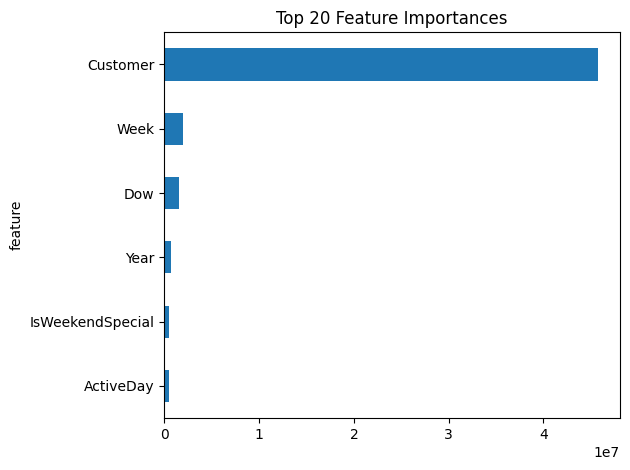

In [15]:
# Assuming your model is named 'model' and has been fitted
importance = model.feature_importance(importance_type='gain')
features = model.feature_name()

# Create DataFrame
feat_df = pd.DataFrame({
    'feature': features,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Plot top 20
feat_df.head(20).plot(kind='barh', x='feature', y='importance', legend=False)
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
y_test_modified = y_test.fillna(0).to_numpy()
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

rmse = mean_squared_error(y_test_modified, y_pred)
print(f"RMSE: {rmse}")


RMSE: 0.03672304614553878


In [17]:
true = true[true["DateTime"] >= date]
true = true.set_index(["DateTime"])

true.head()

,Customer,Consumption
DateTime,,
2024-07-01 00:00:00,ES_1,0.001040
2024-07-01 00:00:00,IT_1,0.001842
2024-07-01 01:00:00,ES_1,0.000940
2024-07-01 01:00:00,IT_1,0.001901
2024-07-01 02:00:00,ES_1,0.000948


In [18]:
pivoted_true = true.pivot(columns="Customer", values="Consumption")
pivoted_true.head()

Customer,ES_1,ES_100,ES_104,ES_107,ES_109,ES_11,ES_114,ES_115,ES_117,ES_126,...,IT_982,IT_984,IT_985,IT_987,IT_988,IT_991,IT_992,IT_995,IT_996,IT_998
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.001040,0.030804,0.022380,0.013556,0.054,0.015900,3.962,0.221,0.023,0.002100,...,0.000024,0.001250,0.001850,0.000076,0.005225,0.000896,0.002075,0.003724,0.000514,0.001150
2024-07-01 01:00:00,0.000940,0.028396,0.022268,0.011736,0.057,0.015936,4.231,0.238,0.026,0.002472,...,0.000024,0.001458,0.001975,0.000076,0.005075,0.000896,0.002075,0.003750,0.000510,0.001175
2024-07-01 02:00:00,0.000948,0.027264,0.021696,0.011896,0.054,0.016892,4.306,0.228,0.026,0.001580,...,0.000024,0.001382,0.001825,0.000076,0.005250,0.000896,0.002125,0.003750,0.000513,0.001175
2024-07-01 03:00:00,0.001084,0.027984,0.022368,0.016124,0.054,0.015104,4.122,0.219,0.022,0.002496,...,0.000024,0.001058,0.001875,0.000076,0.005125,0.000896,0.002300,0.003700,0.000485,0.001175
2024-07-01 04:00:00,0.000832,0.031076,0.021436,0.014236,0.053,0.035684,4.206,0.211,0.042,0.003068,...,0.000024,0.001352,0.001950,0.000076,0.005250,0.000896,0.002550,0.003775,0.000536,0.001150


In [19]:
it_df_true = pivoted_true.filter(like='IT_', axis=1)
es_df_true = pivoted_true.filter(like='ES_', axis=1)
it_df_true.head()

Customer,IT_1,IT_100,IT_1002,IT_1007,IT_1008,IT_1009,IT_101,IT_1010,IT_1011,IT_1012,...,IT_982,IT_984,IT_985,IT_987,IT_988,IT_991,IT_992,IT_995,IT_996,IT_998
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.001842,0.086516,0.000675,0.000012,0.0,0.001228,0.018,0.001248,0.024578,0.010799,...,0.000024,0.001250,0.001850,0.000076,0.005225,0.000896,0.002075,0.003724,0.000514,0.001150
2024-07-01 01:00:00,0.001901,0.083981,0.000700,0.000013,0.0,0.001228,0.015,0.001250,0.025183,0.010950,...,0.000024,0.001458,0.001975,0.000076,0.005075,0.000896,0.002075,0.003750,0.000510,0.001175
2024-07-01 02:00:00,0.001853,0.084220,0.000700,0.000012,0.0,0.001228,0.018,0.001252,0.003412,0.010800,...,0.000024,0.001382,0.001825,0.000076,0.005250,0.000896,0.002125,0.003750,0.000513,0.001175
2024-07-01 03:00:00,0.001917,0.084437,0.000675,0.000012,0.0,0.001228,0.021,0.001254,0.003431,0.010950,...,0.000024,0.001058,0.001875,0.000076,0.005125,0.000896,0.002300,0.003700,0.000485,0.001175
2024-07-01 04:00:00,0.001853,0.079521,0.000700,0.000014,0.0,0.001228,0.021,0.001258,0.003402,0.011100,...,0.000024,0.001352,0.001950,0.000076,0.005250,0.000896,0.002550,0.003775,0.000536,0.001150


In [20]:
X_test = X[X["DateTime"] >= date]
X_test = X_test.set_index(["DateTime"])
X_test


,Day,Month,Year,Dow,DayYear,Week,Season,IsWeekend,IsWeekendSpecial,ActiveDay,temp,spv,Customer
DateTime,,,,,,,,,,,,,
2024-07-01 00:00:00,1,7,2024,0,183,27,3,False,True,False,19.5,0.000000,ES_1
2024-07-01 00:00:00,1,7,2024,0,183,27,3,False,True,False,20.5,0.000000,IT_1
2024-07-01 01:00:00,1,7,2024,0,183,27,3,False,True,False,18.9,0.000000,ES_1
2024-07-01 01:00:00,1,7,2024,0,183,27,3,False,True,False,20.2,0.000000,IT_1
2024-07-01 02:00:00,1,7,2024,0,183,27,3,False,True,False,18.3,0.000000,ES_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 19:00:00,31,7,2024,2,213,31,3,False,False,True,30.8,816.702204,IT_2852
2024-07-31 20:00:00,31,7,2024,2,213,31,3,False,False,True,29.3,102.753383,IT_2852
2024-07-31 21:00:00,31,7,2024,2,213,31,3,False,False,False,27.7,0.000000,IT_2852


In [21]:
pred = pd.DataFrame(y_pred, index=true.index, columns=['Consumption'])
pred['name'] = X_test['Customer']
pred

,Consumption,name
DateTime,,
2024-07-01 00:00:00,0.010075,ES_1
2024-07-01 00:00:00,0.010075,IT_1
2024-07-01 01:00:00,0.010075,ES_1
2024-07-01 01:00:00,0.010075,IT_1
2024-07-01 02:00:00,0.010075,ES_1
...,...,...
2024-07-31 19:00:00,0.023157,IT_2852
2024-07-31 20:00:00,0.023157,IT_2852
2024-07-31 21:00:00,0.014511,IT_2852


In [22]:
pivoted_pred = pred.pivot(columns='name', values='Consumption')
pivoted_pred.head()

name,ES_1,ES_100,ES_104,ES_107,ES_109,ES_11,ES_114,ES_115,ES_117,ES_126,...,IT_982,IT_984,IT_985,IT_987,IT_988,IT_991,IT_992,IT_995,IT_996,IT_998
DateTime,,,,,,,,,,,,,,,,,,,,,
2024-07-01 00:00:00,0.010075,0.021287,0.035466,0.010075,0.061288,0.023614,3.364299,0.476835,0.036933,0.010075,...,0.010075,0.010075,0.010075,0.010075,0.020894,0.010075,0.010075,0.010075,0.010075,0.010075
2024-07-01 01:00:00,0.010075,0.021287,0.035466,0.010075,0.061288,0.023614,3.364299,0.476835,0.036933,0.010075,...,0.010075,0.010075,0.010075,0.010075,0.020894,0.010075,0.010075,0.010075,0.010075,0.010075
2024-07-01 02:00:00,0.010075,0.021287,0.035466,0.010075,0.061288,0.023614,3.364299,0.476835,0.036933,0.010075,...,0.010075,0.010075,0.010075,0.010075,0.020894,0.010075,0.010075,0.010075,0.010075,0.010075
2024-07-01 03:00:00,0.010075,0.021287,0.035466,0.010075,0.061288,0.023614,3.364299,0.476835,0.036933,0.010075,...,0.010075,0.010075,0.010075,0.010075,0.020894,0.010075,0.010075,0.010075,0.010075,0.010075
2024-07-01 04:00:00,0.010075,0.021287,0.035466,0.010075,0.061288,0.023614,3.364299,0.476835,0.036933,0.010075,...,0.010075,0.010075,0.010075,0.010075,0.020894,0.010075,0.010075,0.010075,0.010075,0.010075


In [23]:
it_df_pred = pivoted_pred.filter(like='IT_', axis=1)
es_df_pred = pivoted_pred.filter(like='ES_', axis=1)

In [24]:
mask_it = X_test['Customer'].apply(lambda x: x.startswith("IT_"))
mask_es = X_test['Customer'].apply(lambda x: x.startswith("ES_"))
mask_it

DateTime
2024-07-01 00:00:00    False
2024-07-01 00:00:00     True
2024-07-01 01:00:00    False
2024-07-01 01:00:00     True
2024-07-01 02:00:00    False
                       ...  
2024-07-31 19:00:00     True
2024-07-31 20:00:00     True
2024-07-31 21:00:00     True
2024-07-31 22:00:00     True
2024-07-31 23:00:00     True
Name: Customer, Length: 1334736, dtype: bool

In [25]:
mask_it = mask_it.reset_index(drop=True)
mask_es = mask_es.reset_index(drop=True)

y_test = y_test.reset_index(drop=True)


In [26]:
pred_it = y_pred[mask_it]
pred_es = y_pred[mask_es]
true_it = y_test[mask_it]
true_es = y_test[mask_es]

In [27]:
print("Shape of pred_it:", y_pred.shape)
print("Shape of true_it:", y_test.shape)

Shape of pred_it: (1334736,)
Shape of true_it: (1334736, 1)


In [28]:
pd.isna(it_df_true).sum().sum()

np.int64(4196)

In [29]:
evaluate(pred_it=it_df_pred.fillna(0), true_it=it_df_true.fillna(0), pred_es=es_df_pred.fillna(0), true_es=es_df_true.fillna(0))


                 FORECAST EVALUATION REPORT                 

IT PERFORMANCE
------------------------------------------------------------

Metric                  Score  Weight  Weighted Score
Absolute Error   77146.787450     1.0    77146.787450
Portfolio Error  23012.270238    10.0   230122.702382

Top 3 consumers with highest error in Italy:

name
IT_1689    1367.65
IT_506     1361.09
IT_274      938.18

ES PERFORMANCE
------------------------------------------------------------

Metric                 Score  Weight  Weighted Score
Absolute Error   9302.046521     5.0    46510.232606
Portfolio Error  2964.935441    50.0   148246.772038

Top 3 consumers with highest error in Spain:

name
ES_70     1041.57
ES_307     621.41
ES_114     618.51

------------------------------------------------------------
                    TOTAL FORECAST SCORE                    
                           502026                           
------------------------------------------------------------

